In [1]:
import pandas as pd
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import numpy as np
from matplotlib import pyplot as plt
import os
from pathlib import Path
from torch import nn
from torch.utils.data import Dataset, DataLoader, random_split
import torch

In [2]:
class DiffFER(Dataset):
    def __init__(self, data):
        super().__init__()
        sc = MinMaxScaler()
        # everything in pytorch needs to be a tensor
        label_cols=['valence', 'arousal']
        self.labels = torch.tensor(sc.fit_transform(data[label_cols].to_numpy(dtype=np.float32)))
        self.inputs = torch.tensor(data.drop(label_cols, axis=1).to_numpy(dtype=np.float32))

    def __getitem__(self, index):
        return self.inputs[index], self.labels[index]

    def __len__(self):
        return len(self.inputs)

In [3]:
path=Path(os.getcwd()).parent
DIR_PATH=str(path) + '\\'

In [4]:
dataset = pd.read_csv(DIR_PATH + r'data/extracted_df.csv')
#dataset.head(5)
cols=['AU01', 'AU02', 'AU04', 'AU05', 'AU06', 'AU07', 'AU09', 'AU10', 'AU11',
       'AU12', 'AU14', 'AU15', 'AU17', 'AU20', 'AU23', 'AU24', 'AU25', 'AU26',
       'AU28', 'AU43',  'valence', 'arousal']
data = dataset[cols]


In [5]:
data['arousal'].mean(), data['arousal'].max(), data['arousal'].min(), data['arousal'].std() 

(0.22038910505836576, 1.0, -0.3, 0.2573314490060687)

In [6]:
data['valence'].mean(), data['valence'].max(), data['valence'].min(), data['valence'].std() 

(-0.03307392996108951, 0.7, -1.0, 0.34483771746096264)

In [5]:
#Seperating the images based on the valence 
pos_val= data[data['valence'] > 0].drop(columns=[ 'valence'])
neg_val= data[data['valence'] < 0].drop(columns=[ 'valence'])

#Seperating the images based on the valence s
absolute_diff_aus= abs(pos_val.mean() - neg_val.mean()).sort_values(ascending=False)

([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20],
 [Text(0, 0, 'AU12'),
  Text(1, 0, 'AU07'),
  Text(2, 0, 'AU06'),
  Text(3, 0, 'AU43'),
  Text(4, 0, 'AU14'),
  Text(5, 0, 'AU11'),
  Text(6, 0, 'AU10'),
  Text(7, 0, 'AU09'),
  Text(8, 0, 'AU26'),
  Text(9, 0, 'AU24'),
  Text(10, 0, 'AU28'),
  Text(11, 0, 'AU20'),
  Text(12, 0, 'AU02'),
  Text(13, 0, 'AU05'),
  Text(14, 0, 'AU23'),
  Text(15, 0, 'AU17'),
  Text(16, 0, 'AU25'),
  Text(17, 0, 'AU04'),
  Text(18, 0, 'arousal'),
  Text(19, 0, 'AU15'),
  Text(20, 0, 'AU01')])

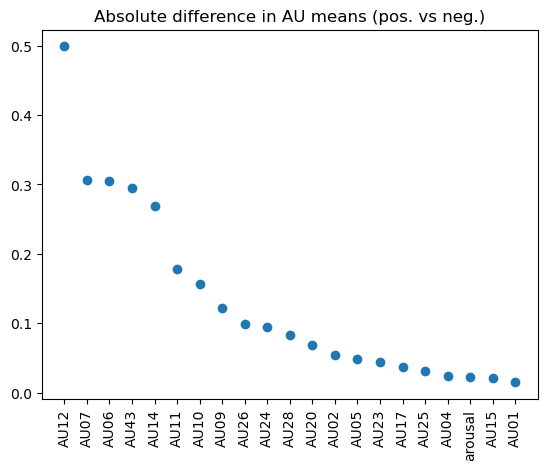

In [6]:
fig = plt.figure()
plt.plot(absolute_diff_aus,  linestyle=' ', marker='o')
plt.title('Absolute difference in AU means (pos. vs neg.)')
plt.autoscale(enable=True, axis='x')
plt.xticks(rotation=90)

In [7]:
cols=['AU06', 'AU07', 'AU12', 'AU14', 'AU43',  'valence', 'arousal']
data = dataset[cols]

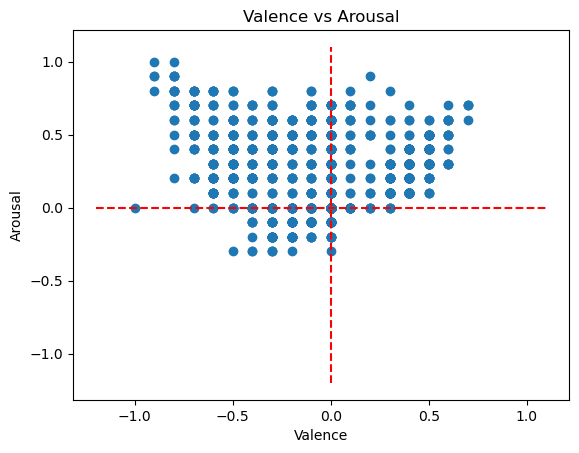

In [103]:
x1=[ 0*x/10 for x in range(-12,12,1)]
y1=[ x/10 for x in range(-12,12,1)]

x2=[ x/10 for x in range(-12,12,1)]
y2=[ 0*x/10 for x in range(-12,12,1)]

plt.title('Valence vs Arousal')
plt.xlabel('Valence')
plt.ylabel('Arousal')
plt.autoscale(enable=True, axis='x')
plt.scatter(dataset['valence'].values, dataset['arousal'].values, marker='o')
plt.plot(x1, y1, linestyle='--', color='r')
plt.plot(x2, y2, linestyle='--', color='r')
plt.show()

In [ ]:
# print("Unique classes", dataset["expression"].unique(), "\n")

# # see class balance
# def check(cl):
#     expression = {"anger": 0, "disgust": 1, "fear": 2, "happiness": 3, "neutral": 4, "sadness": 5, "surprise": 6}
#     for c,i in expression.items():
#         if cl==i:
#             return c
# check(1)
# daa={}
# counts=[]
# emos=[]
# for class0 in dataset["expression"].unique():
#     counts.append( (dataset['expression'] == class0).value_counts().iloc[1] )
#     emos.append(check(class0))
#     print(f"{(dataset['expression'] == class0).value_counts().iloc[1]}, {check(class0)}")
# daa['emos'] = emos
# daa['counts'] = counts
# print(daa)
# k= pd.DataFrame(daa)
# k.to_csv(DIR_PATH + 'scratch/daa.csv', index=False)

In [7]:
class MLP(nn.Module):
    def __init__(self, features_in=2, features_out=3):
        super().__init__()

        self.net = nn.Sequential(
            nn.Linear(features_in, 15),
            nn.ReLU(),
            nn.Linear(15, features_out)
            #nn.Linear(features_in, features_out)
        )
    def forward(self, input):
        return self.net(input)

In [17]:
class RMSELoss(torch.nn.Module):
    def __init__(self):
        super(RMSELoss,self).__init__()

    def forward(self,x,y):
        criterion = nn.MSELoss()
        loss = torch.sqrt(criterion(x, y))
        return loss

In [21]:
dat=DiffFER(data)

# passing a generator to random_split is similar to specifying the seed in sklearn
generator = torch.Generator().manual_seed(2023)

# this can also generate multiple sets at the same time with e.g. [0.7, 0.2, 0.1]
train, test = random_split(dat, [0.7, 0.3], generator=generator)

train_loader = DataLoader(  # this loads the data that we need dynamically
    train,
    batch_size=16,  # instead of taking 1 data point at a time we can take more, making our training faster and more stable
    shuffle=True  # Shuffles the data between epochs (see below)
)

test_loader = DataLoader(  # this loads the data that we need dynamically
    test,
    batch_size=16,  # instead of taking 1 data point at a time we can take more, making our training faster and more stable
    shuffle=True  # Shuffles the data between epochs (see below)
)

In [22]:
model = MLP(train[0][0].shape[0], dat.labels.shape[1])

optim = torch.optim.Adam(model.parameters(), lr=0.0001)

loss_fn = RMSELoss()

# Check if we have GPU acceleration, if we do our code will run faster
device = "cuda" if torch.cuda.is_available() else "cpu"
# if you are on mac with the new M1, M2, ... chips you can try the following instead of cuda
device = "mps" if torch.backends.mps.is_available() else device

print(f"Using device: {device}")

# we need to move our model to the correct device
model = model.to(device)

epochs=400

Using device: cuda


In [23]:
losses=[]
test_l=[]
combined_acc=[]
best_rmse=0.0
for epoch in range(epochs):
    correct = 0
    n_correct=0
    model.train()
    for inputs, labels in train_loader:
        # both input, output and model need to be on the same device
        inputs = inputs.to(device)
        labels = labels.to(device)
        out = model(inputs)
        correct += torch.bitwise_and(out > 0, labels > 0).sum().cpu()
        n_correct += torch.bitwise_and(out < 0, labels < 0).sum().cpu()
        loss = loss_fn(out, labels)
        losses.append(loss.item())
        loss.backward()
        optim.step()
        optim.zero_grad()
    combined_acc.append(100* (correct + n_correct)/(2*len(train)))
        # evaluate accuracy at end of each epoch
    model.eval()
    for inputs, labels in test_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)
        y_pred = model(inputs)
        rmse = loss_fn(y_pred, labels)
        test_l.append(rmse.item())
        rmse = float(rmse)
        if rmse < best_rmse:
            best_rmse = rmse
    print(f"epoch = {epoch}, RMSE = {loss}")


epoch = 0, RMSE = 0.6357763409614563
epoch = 1, RMSE = 0.43993300199508667
epoch = 2, RMSE = 0.521030068397522
epoch = 3, RMSE = 0.4105137586593628
epoch = 4, RMSE = 0.4510326683521271
epoch = 5, RMSE = 0.4646660387516022
epoch = 6, RMSE = 0.4600820541381836
epoch = 7, RMSE = 0.3861985504627228
epoch = 8, RMSE = 0.417367160320282
epoch = 9, RMSE = 0.27680090069770813
epoch = 10, RMSE = 0.25812309980392456
epoch = 11, RMSE = 0.20018631219863892
epoch = 12, RMSE = 0.2227421998977661
epoch = 13, RMSE = 0.1690651774406433
epoch = 14, RMSE = 0.13357292115688324
epoch = 15, RMSE = 0.0851273313164711
epoch = 16, RMSE = 0.16974836587905884
epoch = 17, RMSE = 0.26176705956459045
epoch = 18, RMSE = 0.22273516654968262
epoch = 19, RMSE = 0.0928819552063942
epoch = 20, RMSE = 0.1353553980588913
epoch = 21, RMSE = 0.2510609030723572
epoch = 22, RMSE = 0.14972153306007385
epoch = 23, RMSE = 0.16895633935928345
epoch = 24, RMSE = 0.1380406618118286
epoch = 25, RMSE = 0.12261377274990082
epoch = 26, R

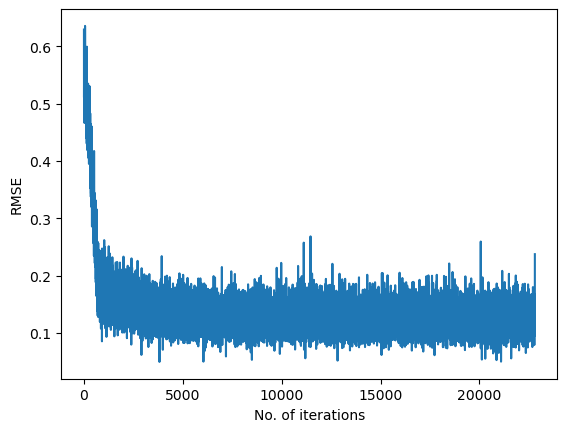

In [30]:
plt.plot(losses)
plt.xlabel("No. of iterations")
plt.ylabel("RMSE")
plt.show()

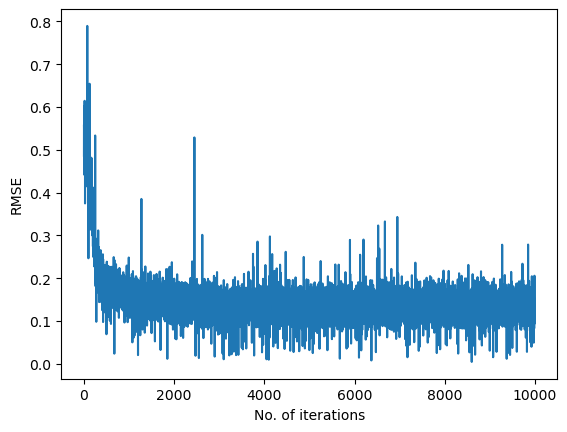

In [31]:
plt.plot(test_l)
plt.xlabel("No. of iterations")
plt.ylabel("RMSE")
plt.show()

In [33]:
np.mean(test_l), np.std(test_l)

(0.14124225119138137, 0.0557920464019181)

In [ ]:
op = model(torch.tensor())

In [ ]:
torch.save(model, DIR_PATH + f'models/ValAr/model1.pt')